 E. coli fed-batch simulation
Created on Thu Dec 10 12:14:22 2015

@author: Terrance Wilms, Nicolas Cruz, Kevin Stegemann, Rosa Haßfurther Updated Sept 2024

In this Python Script the ODE (Ordinary Differential Equation)
of an Ecoli model is solved with the Python ODE Solver odeint.

In [ ]:
# import packages
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline
#%matplotlib qt

In [ ]:
# discretizing the time
dt = 0.01

# defining the initial time
t0 = 0

# defining the end-time
T = 8 #h

# generation of the time-points
t = np.linspace(t0, T, int(T/dt)+1)

In [ ]:
# initial values at time 0
X0   = 0.0358     # Biomass [g/L]
S0   = 5          # Substrate [g/L]
DOT0 = 90         # Dissolved oxygen [%]
A0   = 0          # Acetate [g/L]
V0   = 0.0013     # Volume [L]

# process parameters
Feedstart = 6
Feedrate  = 0.00001
Si        = 200
Fout      = 0
KLa       = 600

# define initial condition and save it in the y
y0 = [X0, S0, DOT0, A0, V0]

In [ ]:
# define the function
def eColi(y, t):
    X   = y[0]
    S   = y[1]
    DOT = y[2]
    A   = y[3]
    V   = y[4]

    # process parameters
    if t < Feedstart:
        F1 = 0
    else:
        F1 = Feedrate

    # parameters describing the characteristics of the strain
    qAmax   = 1           # max Acetate consumption rate [g/g*h]
    Kaq     = 0.01        # affinity constant Acetate consumption [g/L]
    Ksq     = 0.1         # affinity constnat Substrate consumption [g/L]
    Yam     = 0.2         # yield acetate maintenance [g/g]
    Yaresp  = 0.2         # yield acetate respiratory [g/g]
    Yem     = 0.56        # yield excluding maintance [g/g]
    qSmax   = 1.4         # max glucose uptake rate [g/g*h]
    Ks      = 0.05        # affinity constant glucose consumption[g/L]
    qm      = 0.04        # specific maintenance coefficient[g/g*h]
    Ko      = 1           # Affinity constant, oxygen consumption [g/L]
    Yosresp = 1.217       # yield from S to X, respiratory [g/g]
    pAmax   = 1           # max Acetate production rate [g/g*h]
    Kap     = 10          # affinity constant intracellular acetate production[g/L]
    Yaof    = 1           # aceate yield in overflow[g/g]
    Yofm    = Yem         # [g/g]

    # physicochemical constants
    Cs      = 0.391       # ratio of substrate per C in [gC/gS]
    Cx      = 0.488       # ratio of biomass per C in [gC/gX]
    H       = 14000       # conversion factor
    DOTstar = 90

    # algebraic variables
    qS   = qSmax * S / (S + Ks) * DOT / (DOT + Ko)     # substrate uptake
    qSof = pAmax * qS / ( qS + Kap ) / Yaof            # overflow substrate conversion
    pA   = pAmax * qS / (qS + Kap)                     # production of acetate
    qSox = qS - qSof                                   # substrate uptake excluding overflow
    qSan =(qSox - qm) * Yem * Cx / Cs                  # anabolic substrate consumption
    qsA  = qAmax * A / (A + Kaq) * (Ksq / (Ksq + qS))  # acetate consumption
    qA   = pA - qsA                                    # total acetate equilibrium
    qO   = Yosresp * (qSox - qSan) + qsA * Yaresp      # oxygen uptake

    # growht rate equation
    my =(qSox - qm) * Yem + qsA * Yam + qSof * Yofm

    # differential equation system
    dXdt   = -F1 / V * X + my * X                   # biomass growth
    dSdt   = -F1 / V * S - qS * X + F1 / V * Si     # substrate evolution
    dDOTdt = KLa * (DOTstar - DOT) - qO * X * H     # oxygen dynamics
    dAdt   = qA * X - F1 / V * A                    # aetate evolution
    dVdt   = (F1 - Fout)                            # volume change

    #the solution of odeint is formulated as a system of an ODE
    dydt = [dXdt, dSdt, dDOTdt, dAdt, dVdt]

    return dydt

In [ ]:
# calling the numerical solver to approximate the integral of the differential equation system
y = odeint(eColi, y0, t)

# checking critical variables
print('max biomass =', max(y[:,[0]]))
print('min DOT =', min(y[:,[2]]))

max biomass = [4.37135546]
min DOT = [62.50460914]


# Plotting

<ipython-input-12-8fc807e452e5>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)


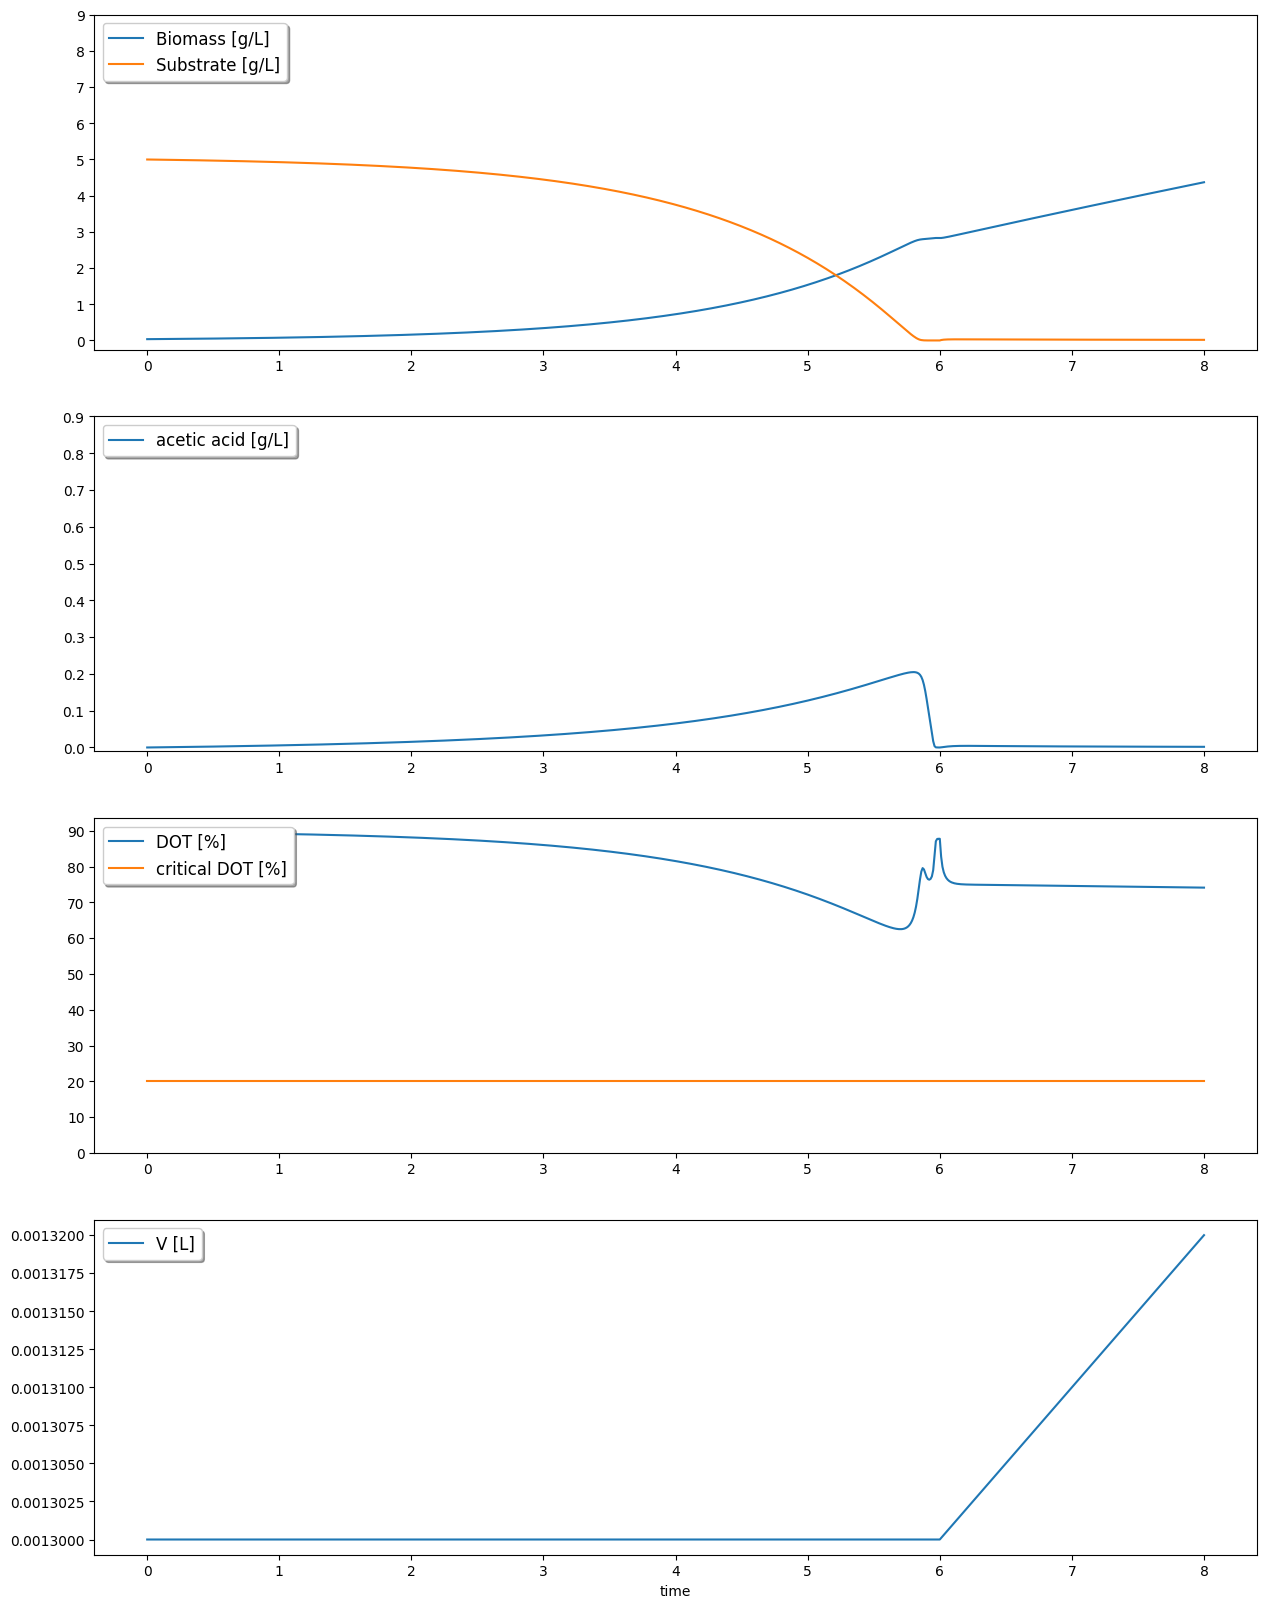

In [ ]:
plt.figure(figsize=(15,20))
plt.title('eColi Model')
#biomass and glucose
plt.subplot(4, 1, 1)
plt.plot(t,y[:,[0]], label = 'Biomass [g/L]')
plt.plot(t,y[:,[1]], label = 'Substrate [g/L]')
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, T + 1, 1))
legend = plt.legend(loc='upper left', shadow=True, prop={'size':12})

# acetate
plt.subplot(4, 1, 2)
plt.plot(t,y[:,[3]], label = 'acetic acid [g/L]')
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, T + 1, 1))
legend = plt.legend(loc='upper left', shadow=True, prop={'size':12})

# Dissolved Oxygen Tension
plt.subplot(4, 1, 3)
plt.plot(t,y[:,[2]], label = 'DOT [%]')
plt.plot([t[0], t[-1]],[20, 20], label = 'critical DOT [%]')
plt.yticks(np.arange(0, 100, 10))
plt.xticks(np.arange(0, T + 1, 1))
legend = plt.legend(loc='upper left', shadow=True, prop={'size':12})

# Volume
plt.subplot(4, 1, 4)
plt.plot(t,y[:,[4]], label = 'V [L]')
plt.xticks(np.arange(0, T + 1, 1))
legend = plt.legend(loc='upper left', shadow=True, prop={'size':12})
plt.xlabel('time')
plt.show()

#plt.savefig('05_ODE_simpleEcoliModel_X_S_DOT_A_V_E.pdf')
#plt.savefig('05_ODE_simpleEcoliModel_X_S_DOT_A_V_E.jpg')

# Tasks

answer the following questions with simulations


*   "optimize" initial value of glucose, starting time of the feedrate, and feedrate to maximize the biomass concentration after 8 hours without DOT dropping below 20%
*   can you propose a solution that automatically starts the feed when glucose is depleted based on the DOT signal?

*   which other process parameter could we change to get an even higher biomass?
*   which of the parameters describing the characteristics of the strain has the highest influence on the final biomass obtained at fixed cultivation time?
